<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# German News Articles

by Joel Akeret and Fabian Märki

## Summary
This is a short intro on how to access the *Ten Thousand German News Articles Dataset* for the *default project* (we still encourage you to work with your own dataset).

## Links
- [Ten Thousand German News Articles Dataset](https://tblock.github.io/10kGNAD/)

<a href="https://colab.research.google.com/github/markif/2021_HS_DAS_NLP_Notebooks/blob/master/XX_German_News_Article.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip install 'fhnw-nlp-utils>=0.1.3' pyarrow fastparquet

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

We propose to use the stratified train/test split proposed by the maintainer of the dataset.

In [2]:
file = "data/german_news_articles_original_train.parq"
download("https://drive.google.com/uc?id=1EuluVm0PX-akbh_EN-jZM2QbxXZ1uDeq", file)
data_train = load_dataframe(file)

file = "data/german_news_articles_original_test.parq"
download("https://drive.google.com/uc?id=1XI2yUaDaAy0PlD-ETiK8VMV_W1vOQ97n", file)
data_test = load_dataframe(file)

Get a first impression...

In [4]:
print("Shape training data", data_train.shape)
print("Shape test data",data_test.shape)

Shape training data (9245, 2)
Shape test data (1028, 2)


In [5]:
data_train["split"] = "train"
data_test["split"] = "test"

In [29]:
# Concat all the data into one dataset
data_all = pd.concat([data_train, data_test])

In [8]:
# What is this Etat category?
data_all[data_all['label'] == 'Etat'].iloc[60, 0]

'Der Film "Crouching Tiger, Hidden Dragon: Sword of Destiny" ist ab Freitag abrufbar. Los Gatos / Wien – Schwertkämpfer und exotische Ninjas, die auf Baumwipfeln gegeneinander kämpfen: Der mehrfach preisgekrönte chinesisch-taiwanische Blockbuster Tiger and Dragon aus dem Jahr 2000 mit Chow Yun-Fat (Anna und der König) bildet die Vorgeschichte für den Martial-Arts-Film Crouching Tiger, Hidden Dragon: Sword of Destiny, der ab Freitag auf Netflix abrufbar ist. Die Regie im zweiten Teil von Tiger and Dragon übernimmt allerdings nicht mehr Ang Lee (Brokeback Mountain, Life of Pi), sondern Yuen Woo-ping. Er hatte schon 1978 den leichtfüßigen Jackie Chan zum Drunken Master (Sie nannten ihn Knochenbrecher) transformiert. Die Geschichte der Netflix-Produktion entführt den Zuschauer in eine mystische Zeit, in der die Gravitation anderen Regeln zu folgen scheint: balancierend auf der Spitze eines Schwertes ausharren, von Baum zu Baum gleiten, mal eben drei Meter hoch springen. Fans, die der chara

Data analysieren. Verteilung der Label

<AxesSubplot:>

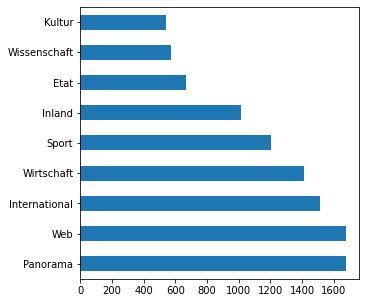

In [10]:
# It seems that the data imbalanced among the 9 classes.
# Kultur + Wissenschaft + Etat together are smaller than largets class Panorama
data_all['label'].value_counts().plot.barh(figsize=(5,5))

Es scheint keine 
- Null Zellen  
- HTML Zellen zu geben
- Zelle ohne Text


In [15]:
print('Null values per column')
for col in data_all.columns:
    print(col, data[col].isnull().sum())
print('\nHtml code in cells?')
print(data[data["text_original"].str.contains("/>", na=False)])
print('\nNon character code in cells')
print(data_all[~data_all["text_original"].str.contains("[A-Za-z]", na=False)])

Null values per column
text_original 0
label 0
split 0

Html code in cells?
Empty DataFrame
Columns: [text_original, label, split]
Index: []

Non character code in cells
Empty DataFrame
Columns: [text_original, label, split]
Index: []


In [16]:
!pip install fasttext
pretrained_model = "fasttext/supervised-models/lid.176.ftz"
download(url="https://dl.fbaipublicfiles.com/"+pretrained_model, path = pretrained_model)

import fasttext
model = fasttext.load_model(pretrained_model)

def predict_lang(text):
    """Predicts the language of a sentence

    Parameters
    ----------
    text : str
        The text to predict the language
        
    Returns
    -------
    str
        The predicted language (e.g. en, de, ...)
    """
        
    lang = model.predict(text)[0]
    return str(lang)[11:13]

def predict_lang_df(df, field_read="text", field_write="lang"):
    """Predicts the language of a column of text by calling predict_lang (primarily meant for parallel processing)

    Parameters
    ----------
    df : dataframe
        The dataframe
    field_read : str
        The column name to read from (default is text)
    field_write : str
        The column name to write to (default is lang)
        
    Returns
    -------
    dataframe
        The dataframe with the predicted language
    """
    
    # do not grow the dataframe directly - see https://stackoverflow.com/a/56746204
    series = df[field_read].map(
        lambda x: predict_lang(x)
    )
    
    return series.to_frame(field_write)

     |████████████████████████████████| 68 kB 771 kB/s eta 0:00:01
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3123956 sha256=34b5b5c85f9c9ba3f586dea94abb6be2a2668a110f95912bceae9022d2f2bacc
  Stored in directory: /root/.cache/pip/wheels/c3/5c/d0/4a725c6ee7df3267d818d3bc9d89bb173b94832f2b9eca6368
Successfully built fasttext
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [17]:
# It seems that the language of all the text cells is german
predict_lang_df(data_all, 'text_original').value_counts()

lang
de      10273
dtype: int64

In [31]:
%%time
# Cleans text by removing html tags, non ascii chars, digits and optionally punctuation
from fhnw.nlp.utils.text import clean_text_df
data_all = parallelize_dataframe(data_all, clean_text_df, field_read="text_original", field_write="text_clean", n_cores=10)

CPU times: user 125 ms, sys: 156 ms, total: 281 ms
Wall time: 568 ms


In [32]:
data_all.sample(3)

,text_original,label,split,text_clean
8171,Parlament verlängerte Ausrufung des Notstands ...,Panorama,train,Parlament verlängerte Ausrufung des Notstands ...
5945,"Ja, wir haben es mit einer Völkerwanderung zu ...",Kultur,train,Ja wir haben es mit einer Völkerwanderung zu t...
1478,Der Streit über den Kurs in der Flüchtlingskri...,Panorama,train,Der Streit über den Kurs in der Flüchtlingskri...


In [33]:
save_dataframe(data_all, "data/german_news_articles_original_train_and_test.parq")

Tokenization, Stemmming adn Lemmatization

In [ ]:
!pip install 'spacy>=3.0.5'
!pip install nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import spacy
!python3 -m spacy download de_core_news_lg

nlp = spacy.load("de_core_news_lg")

import nltk
nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer("german")
stopwords = set(stopwords.words("german"))
#stopwords = set(nlp.Defaults.stop_words)
empty_stopwords = set()

In [34]:
%%time
# Tokenization of cleaned text
from fhnw.nlp.utils.normalize import normalize_df

data_all.drop(columns=['token_clean'], errors='ignore')
data_all = parallelize_dataframe(data_all, normalize_df, stopwords=stopwords, field_read="text_clean", field_write="token_clean", 
            stemmer=None, lemmanizer=None, lemma_with_ner=False, n_cores=10)
data_all.sample(3)

CPU times: user 797 ms, sys: 187 ms, total: 985 ms
Wall time: 3.15 s


,text_original,label,split,text_clean,token_clean
2234,Republikanischer US-Präsidentschaftsbewerber i...,Etat,train,Republikanischer US Präsidentschaftsbewerber i...,"[republikanischer, us, präsidentschaftsbewerbe..."
858,Strengere Nutzungsbedingungen für Microsoft-Di...,Web,train,Strengere Nutzungsbedingungen für Microsoft Di...,"[strengere, nutzungsbedingungen, microsoft, di..."
7092,"Milan-Stürmer leidet an Schambeinentzündung, m...",Sport,train,Milan Stürmer leidet an Schambeinentzündung mö...,"[milan, stürmer, leidet, schambeinentzündung, ..."


(9,)


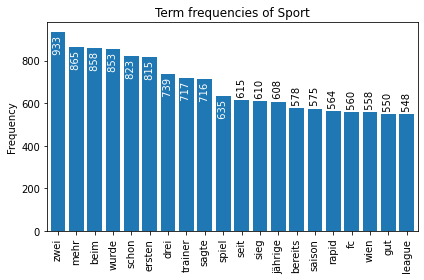

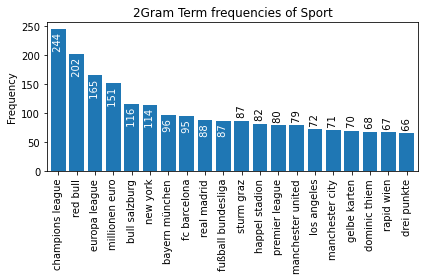

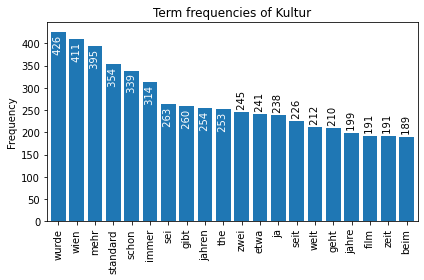

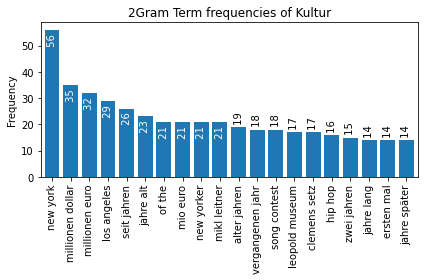

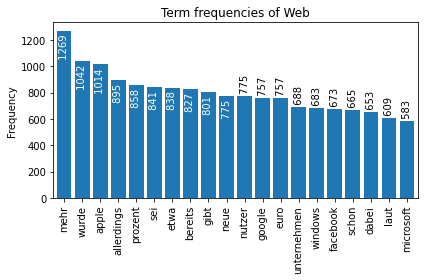

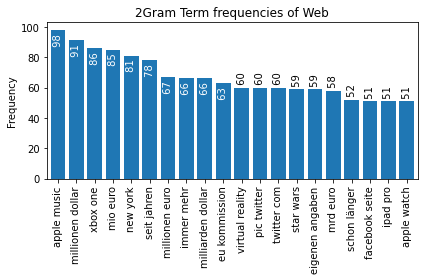

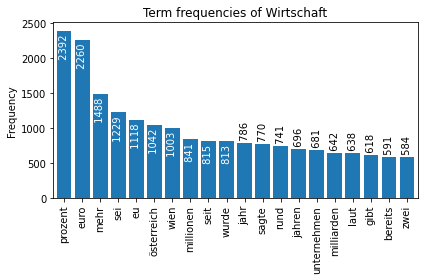

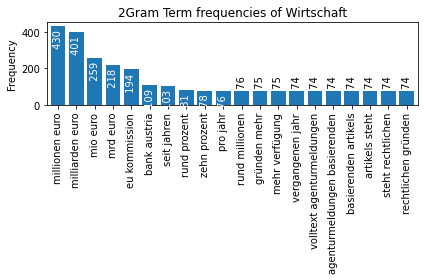

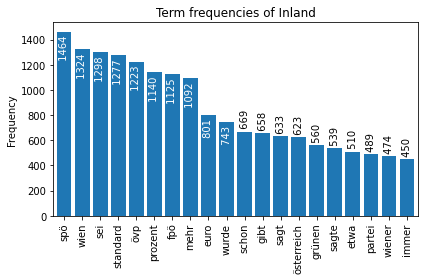

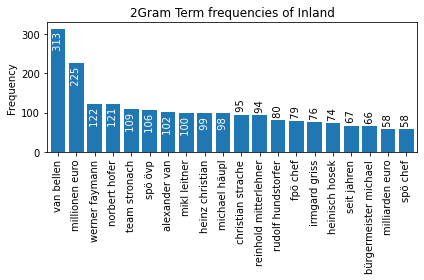

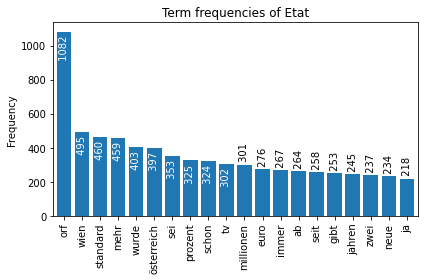

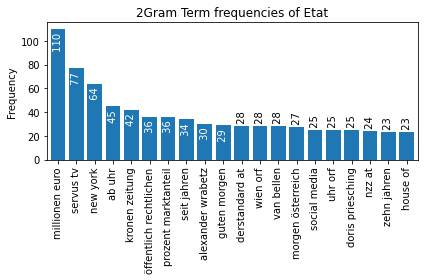

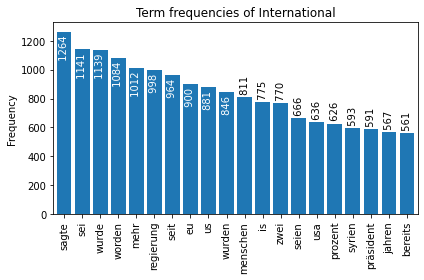

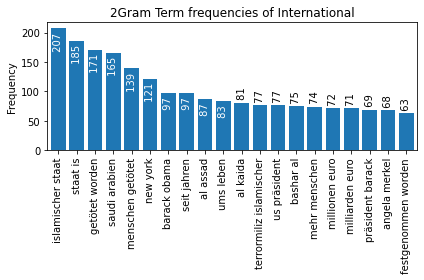

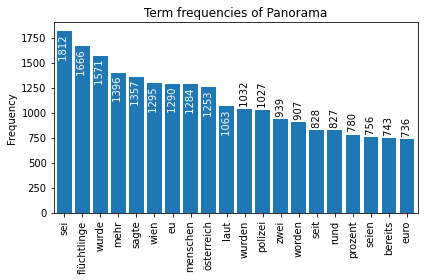

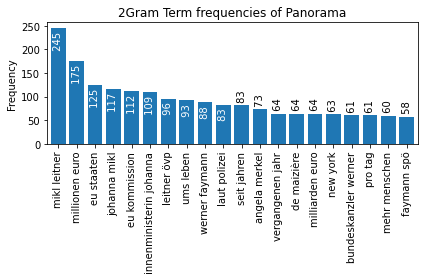

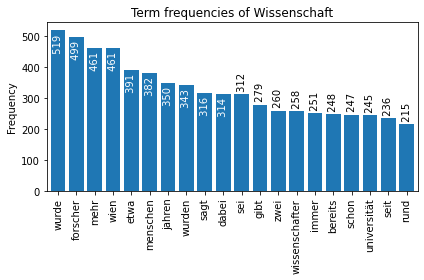

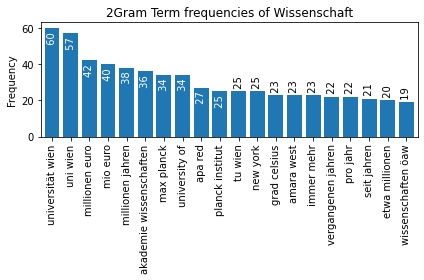

In [55]:
# Very hard to identify additional stop words accoring to the term frequencies. It seems the 3 gram names might
# be important (like Barak Obama, Max Planck, usw.)
from fhnw.nlp.utils.text import create_ngram_counts
from fhnw.nlp.utils.ploting import plot_ngreram_counts

print(axs.shape)
for row, label in enumerate(data_all["label"].unique()):
    ngrams_1 = create_ngram_counts(data_all.loc[(data["label"] == label)], 1, field_read='token_clean')
    ngrams_2 = create_ngram_counts(data_all.loc[(data["label"] == label)], 2, field_read='token_clean')
    
    plot_ngram_counts(ngrams_1, 20, "Term frequencies of "+label)
    plot_ngram_counts(ngrams_2, 20, "2Gram Term frequencies of "+label)


In [56]:
%%time
data_all = data_all.drop(columns=['token_clean'], errors='ignore')
data_all = parallelize_dataframe(data_all, normalize_df, stopwords=stopwords, field_read="text_clean", field_write="token_clean", 
            stemmer=None, lemmanizer=None, lemma_with_ner=False)
data_all

CPU times: user 862 ms, sys: 314 ms, total: 1.18 s
Wall time: 3.02 s


,text_original,label,split,text_clean,token_clean
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,train,Jähriger fällt wohl bis Saisonende aus Wien R...,"[jähriger, fällt, wohl, saisonende, wien, rapi..."
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,train,Erfundene Bilder zu Filmen die als verloren ge...,"[erfundene, bilder, filmen, verloren, gelten, ..."
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,train,Der frischgekürte CEO Sundar Pichai setzt auf ...,"[frischgekürte, ceo, sundar, pichai, setzt, um..."
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",Wirtschaft,train,Putin Einigung dass wir Menge auf Niveau von J...,"[putin, einigung, menge, niveau, jänner, halte..."
4,Estland sieht den künftigen österreichischen P...,Inland,train,Estland sieht den künftigen österreichischen P...,"[estland, sieht, künftigen, österreichischen, ..."
...,...,...,...,...,...
1023,"Programm ""Ebay Plus"" soll Ende September start...",Web,test,Programm Ebay Plus soll Ende September starten...,"[programm, ebay, plus, ende, september, starte..."
1024,"Fehlerhafte Bilanz 2013, Partei will berufen –...",Inland,test,Fehlerhafte Bilanz Partei will berufen Keine S...,"[fehlerhafte, bilanz, partei, berufen, strafe,..."
1025,Als erster Olympia-Champion auch Hawaii-Sieger...,Sport,test,Als erster Olympia Champion auch Hawaii Sieger...,"[erster, olympia, champion, hawaii, sieger, ni..."
1026,Der Außenseiter aus Denver gewinnt die 50. Sup...,Sport,test,Der Außenseiter aus Denver gewinnt die Super B...,"[außenseiter, denver, gewinnt, super, bowl, ca..."


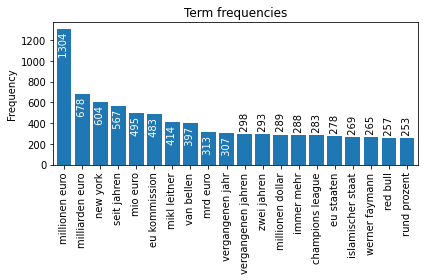

CPU times: user 1.69 s, sys: 890 ms, total: 2.58 s
Wall time: 1.55 s


In [57]:
%%time
from fhnw.nlp.utils.text import create_ngram_counts
from fhnw.nlp.utils.ploting import plot_ngram_counts

ngrams = create_ngram_counts(data_all,  field_read='token_clean')
plot_ngram_counts(ngrams, 20, "Term frequencies")
    


In [61]:
%%time
# see for background info https://nickyreinert.de/blog/2020/12/09/einfuehrung-in-stemming-und-lemmatisierung-deutscher-texte-mit-python/
from fhnw.nlp.utils.normalize import normalize_df 

data_all = data_all.drop(columns=["token_lemma", 'token_stem', 'token_clean_stopwords'], errors='ignore')
# NLP Lemma
data_all = parallelize_dataframe(data_all, normalize_df, field_read="text_clean", field_write="token_lemma", stopwords=stopwords, stemmer=None, lemmanizer=nlp, lemma_with_ner=False, n_cores=6)
# Snowball Stemmer
data_all = parallelize_dataframe(data_all, normalize_df, field_read="text_clean", field_write="token_stem", stopwords=stopwords, stemmer=stemmer, lemmanizer=None, lemma_with_ner=False, n_cores=6)
# Just removing the stopwords
data_all = parallelize_dataframe(data_all, normalize_df, field_read="text_clean", field_write="token_clean_stopwords", stopwords=stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False, n_cores=6)

CPU times: user 36.6 s, sys: 6.77 s, total: 43.4 s
Wall time: 1min 22s


In [62]:
data_all.sample(3)

,text_original,label,split,text_clean,token_clean,token_lemma,token_stem,token_clean_stopwords
1062,Um die für die Bauern prekäre Preissituation b...,Wirtschaft,train,Um die für die Bauern prekäre Preissituation b...,"[bauern, prekäre, preissituation, milch, entsc...","[bauer, prekär, preissituation, milch, entschä...","[bau, prekar, preissituation, milch, entscharf...","[bauern, prekäre, preissituation, milch, entsc..."
1177,"Duell am 16. Juli, Londoner absolvieren danach...",Sport,train,Duell am Juli Londoner absolvieren danach Trai...,"[duell, juli, londoner, absolvieren, danach, t...","[duell, juli, londoner, absolvieren, danach, t...","[duell, juli, london, absolvi, danach, trainin...","[duell, juli, londoner, absolvieren, danach, t..."
8676,"Madrilenen gewinnen in Donezk mit 4:3, Franzos...",Sport,train,Madrilenen gewinnen in Donezk mit Franzosen la...,"[madrilenen, gewinnen, donezk, franzosen, lass...","[madrilenen, gewinnen, donezk, franzose, lasse...","[madril, gewinn, donezk, franzos, lass, malmo,...","[madrilenen, gewinnen, donezk, franzosen, lass..."


In [64]:
%%time
save_dataframe(data_all, "data/german_news_articles_original_train_and_test_tokenized.parq")
data_all.sample(3)

CPU times: user 8.63 s, sys: 119 ms, total: 8.75 s
Wall time: 8.74 s


,text_original,label,split,text_clean,token_clean,token_lemma,token_stem,token_clean_stopwords
8094,Brüderpaar in Haft – Eltern und drei jüngere G...,Panorama,train,Brüderpaar in Haft Eltern und drei jüngere Ges...,"[brüderpaar, haft, eltern, drei, jüngere, gesc...","[brüderpaar, haft, eltern, drei, jung, geschwi...","[bruderpaar, haft, elt, drei, jung, geschwist,...","[brüderpaar, haft, eltern, drei, jüngere, gesc..."
2676,Junge Straftäter können statt in U-Haft in WGs...,Panorama,train,Junge Straftäter können statt in Haft in WGs k...,"[junge, straftäter, statt, haft, wgs, kommen, ...","[junge, straftäter, statt, haft, wgs, kommen, ...","[jung, straftat, statt, haft, wgs, komm, jugen...","[junge, straftäter, statt, haft, wgs, kommen, ..."
1411,Erster Sieg auf prestigeträchtiger US-Dew-Tour...,Sport,train,Erster Sieg auf prestigeträchtiger US Dew Tour...,"[erster, sieg, prestigeträchtiger, us, dew, to...","[erster, sieg, prestigeträchtiger, us-amerikan...","[erst, sieg, prestigetracht, us, dew, tour, os...","[erster, sieg, prestigeträchtiger, us, dew, to..."
